## 加载以往数据
规定每次保存必须按以下格式：
```python
save_checkpoint({
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'avg_loss': avg_loss,
    'min_loaa': min_loss,
    'optimizer' : optimizer.state_dict(),
}, is_best)
```

In [1]:
import torch
import os
import tqdm

import sys
sys.path.append("./model")
from utils.checkpoint import save_checkpoint

if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.backends.cudnn.benchmark = True   # 加速卷积计算
else:
    device = torch.device('cpu')
# device = torch.device('cpu')
print(device)

cuda


In [2]:
from data.septimbre.data import Instruments
dataset = Instruments(
    folder = 'data/septimbre/small',
    mix = 2,
    input = '.cqt.npy',
    output = '.npy'
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=3, shuffle=True, pin_memory=True, num_workers=4)
print("训练集大小: ", len(dataset))

val = Instruments(
    folder = 'data/septimbre/tiny',
    mix = 2,
    input = '.cqt.npy',
    output = '.npy'
)
valloader = torch.utils.data.DataLoader(val, batch_size=4, shuffle=True)
print("测试集大小: ", len(val))

训练集大小:  2916
测试集大小:  900


# 训练具备分离能力的网络
/model/resepnet.py

In [3]:
from resepnet import ReSepNet
model = ReSepNet().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
checkpoint_path = "resepnet.pth"
loss_path = "resepnet.loss.txt"
min_loss = float('inf')
epoch_now = 0

In [4]:
if os.path.isfile(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, weights_only=False, map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    min_loss = checkpoint['min_loss']
    avg_loss = checkpoint['avg_loss']
    epoch_now = checkpoint['epoch']
    print(f"Checkpoint loaded from '{checkpoint_path}'\nepoch: {epoch_now}, loss: {avg_loss}, min_loss: {min_loss}")
else:
    print("Checkpoint file does not exist. Training from scratch.")

Checkpoint file does not exist. Training from scratch.


In [5]:
# 用半精度加速
from torch.amp import GradScaler, autocast
scaler = GradScaler()	# 实例化对象

epoch_total = 100
stage_save_interval = 5    # save checkpoint every $stage_save_interval$ epochs
virtual_batch_size = 4      # 梯度累积 因为8G显存只能跑batch=1

optimizer.zero_grad()
for epoch in range(epoch_now+1, epoch_total):
    # training
    model.train()
    train_loss = 0
    virtual_batch = 0
    for (input, target) in tqdm.tqdm(dataloader):
        input = input.to(device)
        target = target.to(device)

        # 迭代分离
        with autocast(device_type='cuda'):
            onsets = []
            notes = []
            reconstrs = []
            next_input = torch.sum(input, dim=1, keepdim=False)  # 混合后的CQT
            next_input = next_input + torch.randn_like(next_input) * 0.01   # 加入噪声
            for i in range(dataset.mix):
                onset, note, reconstr = model(next_input)
                onsets.append(onset)
                notes.append(note)
                reconstrs.append(reconstr)
                next_input = next_input - reconstr
            onset = torch.stack(onsets, dim=1)
            note = torch.stack(notes, dim=1)
            reconstr = torch.stack(reconstrs, dim=1)
            loss = ReSepNet.loss(onset, note, reconstr, target, input)
            train_loss += loss.item()
            # 梯度累积
            loss = loss / virtual_batch_size

        # loss.backward()
        scaler.scale(loss).backward()
        virtual_batch = (virtual_batch + 1) % virtual_batch_size
        if virtual_batch == 0:
            # optimizer.step()
            scaler.step(optimizer)	# 调整lr
            scaler.update()		# 更新梯度
            optimizer.zero_grad()
    
    if virtual_batch != 0:
        # optimizer.step()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    train_loss /= len(dataloader)

    # validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for (input, target) in tqdm.tqdm(valloader):
            input = input.to(device)
            target = target.to(device)

            # 迭代分离
            onsets = []
            notes = []
            reconstrs = []
            next_input = torch.sum(input, dim=1, keepdim=False)  # 混合后的CQT
            for i in range(dataset.mix):
                onset, note, reconstr = model(next_input)
                onsets.append(onset)
                notes.append(note)
                reconstrs.append(reconstr)
                next_input = next_input - reconstr
            onset = torch.stack(onsets, dim=1)
            note = torch.stack(notes, dim=1)
            reconstr = torch.stack(reconstrs, dim=1)

            loss = ReSepNet.loss(onset, note, reconstr, target, input)
            val_loss += loss.item()

        val_loss /= len(valloader)

    # save checkpoint
    checkpoint_filename = f"epoch{epoch}.pth" if epoch % stage_save_interval == 0 else checkpoint_path
    save_checkpoint({
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'min_loss': min_loss,
        'avg_loss': val_loss,
        'optimizer': optimizer.state_dict(),
    }, val_loss < min_loss, filename = checkpoint_filename)

    if val_loss < min_loss:
        min_loss = val_loss

    print(f"====> Epoch: {epoch} Average train loss: {train_loss:.4f}; Average val loss: {val_loss:.4f}")
    with open(loss_path, 'a') as f:
        f.write(f"{epoch}:\ttrain_loss: {train_loss:.4f}\tval_loss: {val_loss:.4f}\n")
    epoch_now = epoch


100%|██████████| 225/225 [02:30<00:00,  1.49it/s]


====> Epoch: 1 Average train loss: 78271.7600; Average val loss: 9370.6299


100%|██████████| 225/225 [36:36<00:00,  9.76s/it]


====> Epoch: 2 Average train loss: 4658.0538; Average val loss: 5283.5785


100%|██████████| 225/225 [36:35<00:00,  9.76s/it]


====> Epoch: 3 Average train loss: 3680.1943; Average val loss: 5549.0955


100%|██████████| 225/225 [36:04<00:00,  9.62s/it]


====> Epoch: 4 Average train loss: nan; Average val loss: 8808.0054


  0%|          | 3/972 [00:37<3:23:19, 12.59s/it]


KeyboardInterrupt: 

## 测试模型

In [6]:
# 加载最佳模型
best_checkpoint_path = "best_" + checkpoint_path
if os.path.isfile(best_checkpoint_path):
    checkpoint = torch.load(best_checkpoint_path, weights_only=False, map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    min_loss = checkpoint['min_loss']
    avg_loss = checkpoint['avg_loss']
    epoch_now = checkpoint['epoch']
    print(f"Checkpoint loaded from '{checkpoint_path}'\nepoch: {epoch_now}, loss: {avg_loss}, min_loss: {min_loss}")
else:
    raise FileNotFoundError(f"Best checkpoint file {best_checkpoint_path} does not exist.")

Checkpoint loaded from 'resepnet.pth'
epoch: 2, loss: 5283.578491753472, min_loss: 9370.629913194445


In [7]:
device = torch.device('cpu')
model = model.to(device)
torch.backends.cudnn.benchmark = False

In [8]:
# CQT配置
import tomllib
with open('model/config.toml', 'br') as f:
    CQTconfig = tomllib.load(f)['CQT']
s_per_frame = CQTconfig['hop'] / CQTconfig['fs']

from model.CQT import CQTsmall

cqt = CQTsmall(
    CQTconfig['fs'],
    fmin=CQTconfig['fmin'],
    octaves=CQTconfig['octaves'],
    bins_per_octave=CQTconfig['bins_per_octave'],
    hop=CQTconfig['hop'],
    filter_scale=CQTconfig['filter_scale'],
    requires_grad=False
)

In [9]:
# 读取音频，分析为CQT
import torchaudio
from utils.midiarray import numpy2midi
from utils.wavtool import waveInfo
import matplotlib.pyplot as plt
import numpy as np

test_wave_path = "data/inferMusic/short mix.wav"
# test_wave_path = r'C:\amt\data\septimbre\small\inst0\0.wav'
waveInfo(test_wave_path)

waveform, sample_rate = torchaudio.load(test_wave_path, normalize=True)
waveform = waveform.unsqueeze(0)
print(waveform.shape)
test_cqt_data = cqt(waveform).to(device)
print(test_cqt_data.shape)

Sample rate: 22050
Channels: 2
Sample width: 2
Number of frames: 199168
Duration (s): 9.032562358276644
data num: 398336
torch.Size([1, 2, 199168])
torch.Size([1, 2, 288, 519])


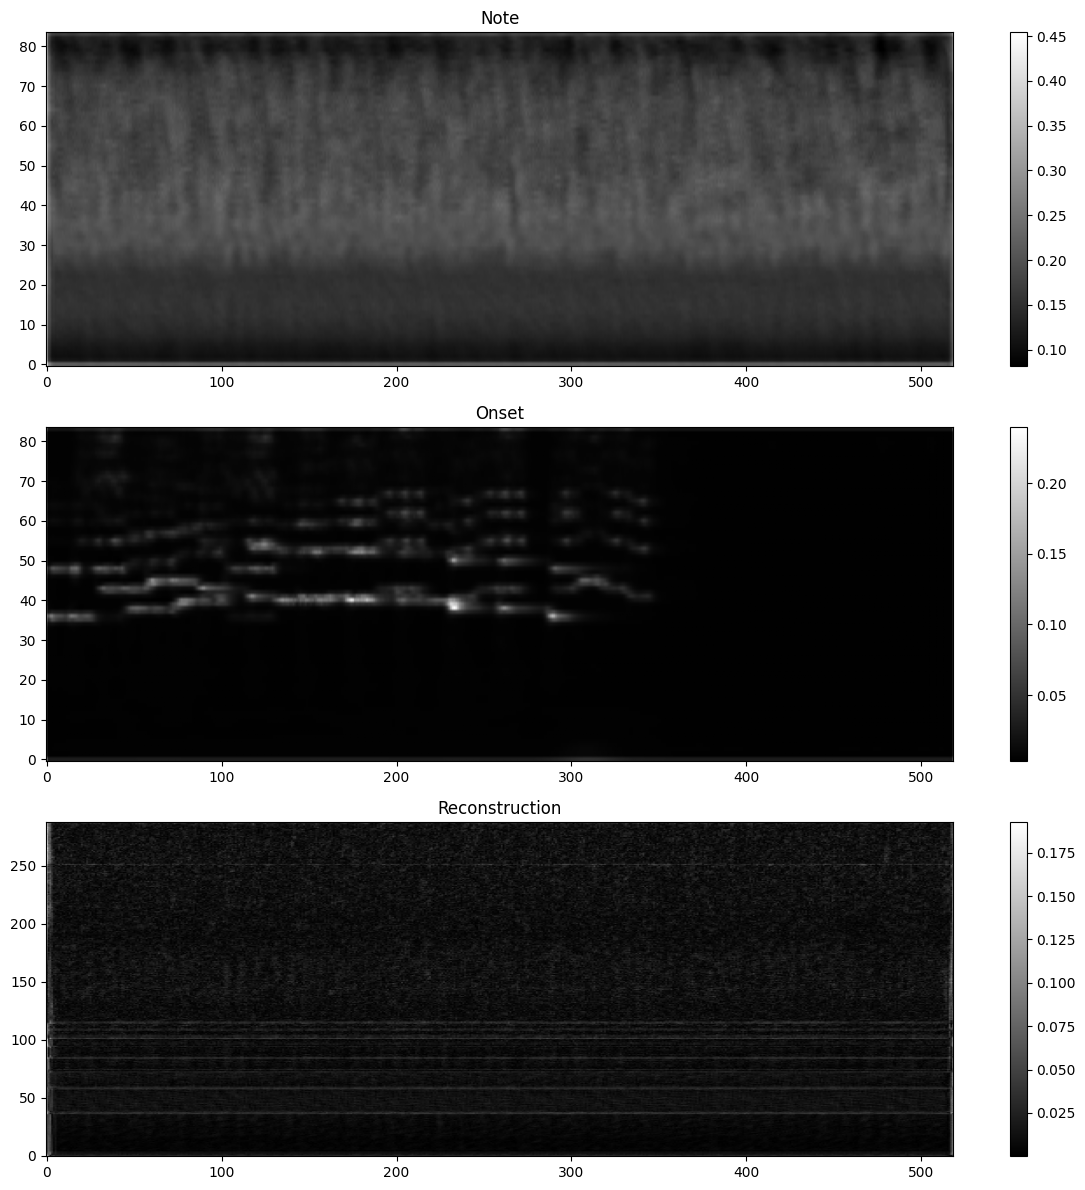

In [10]:
# 迭代分离
model.eval()
with torch.no_grad():
    onset, note, reconstr = model(test_cqt_data)
    onset = onset.cpu().numpy()[0]
    note = note.cpu().numpy()[0]
    test_cqt_data = test_cqt_data - reconstr
    reconstr = reconstr.cpu().numpy()[0]

    plt.figure(figsize=(12, 12))

    plt.subplot(3, 1, 1)
    plt.title('Note')
    plt.imshow(note, aspect='auto', origin='lower', cmap='gray')
    plt.colorbar()

    plt.subplot(3, 1, 2)
    plt.title('Onset')
    plt.imshow(onset, aspect='auto', origin='lower', cmap='gray')
    plt.colorbar()

    plt.subplot(3, 1, 3)
    plt.title('Reconstruction')
    plt.imshow(np.sqrt(np.power(reconstr[0], 2) + np.power(reconstr[1], 2)), aspect='auto', origin='lower', cmap='gray')
    
    plt.colorbar()

    plt.tight_layout()
    plt.show()

    
    

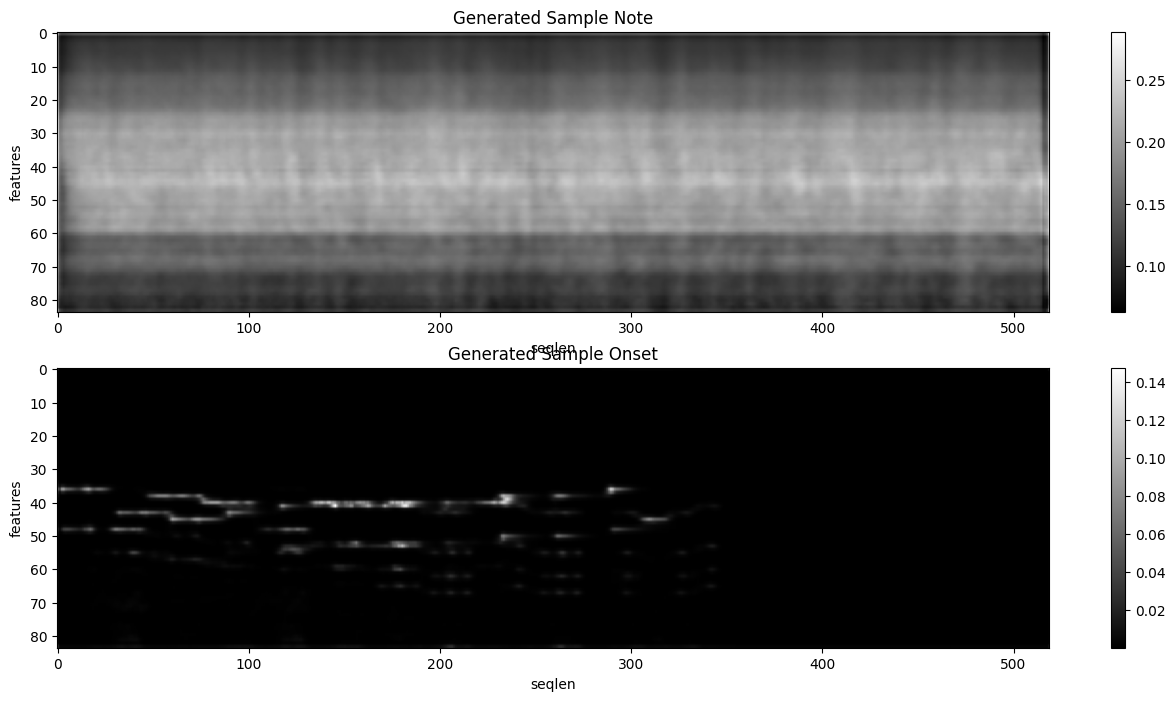

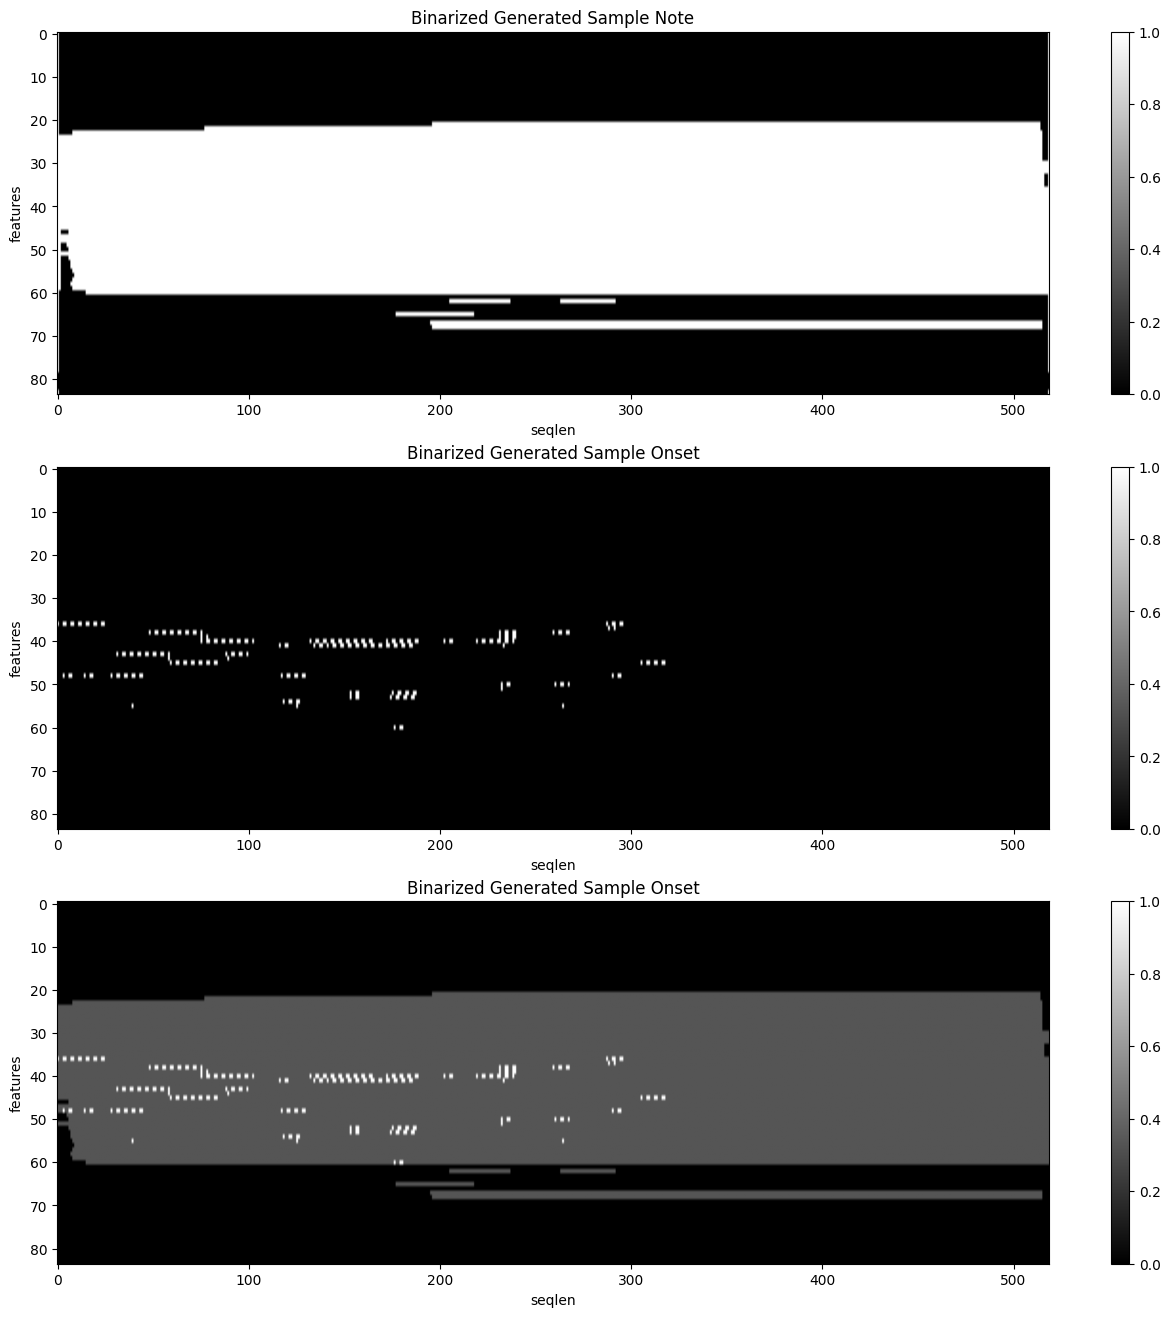

In [23]:
from utils.postprocess import *

fig, axs = plt.subplots(2, 1, figsize=(16, 8))
im1 = axs[0].imshow(note, cmap='gray', aspect='auto')
axs[0].set_title('Generated Sample Note')
axs[0].set_xlabel('seqlen')
axs[0].set_ylabel('features')
fig.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(onset, cmap='gray', aspect='auto')
axs[1].set_title('Generated Sample Onset')
axs[1].set_xlabel('seqlen')
axs[1].set_ylabel('features')
fig.colorbar(im2, ax=axs[1])

note = note + onset
n_threshold = OTSU_threshold(note)
o_threshold = OTSU_threshold(onset)
n_binary = schmitt_binarization(note, n_threshold/1.2, n_threshold)
o_binary = (onset > o_threshold).astype(np.uint8)
# _min_len(n_binary, 4)
_max_len(o_binary, 1, 4)

fig, axs = plt.subplots(3, 1, figsize=(16, 16))
im1 = axs[0].imshow(n_binary, cmap='gray', aspect='auto')
axs[0].set_title('Binarized Generated Sample Note')
axs[0].set_xlabel('seqlen')
axs[0].set_ylabel('features')
fig.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(o_binary, cmap='gray', aspect='auto')
axs[1].set_title('Binarized Generated Sample Onset')
axs[1].set_xlabel('seqlen')
axs[1].set_ylabel('features')
fig.colorbar(im2, ax=axs[1])

note = o_binary*2 + n_binary
_min_len(note, 4)
im3 = axs[2].imshow(note, cmap='gray', aspect='auto')
axs[2].set_title('Binarized Generated Sample Onset')
axs[2].set_xlabel('seqlen')
axs[2].set_ylabel('features')
fig.colorbar(im2, ax=axs[2])

plt.show()